<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/Generate_normal_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Stable diffusionのファインチューニングでnormalの画像を作成したときの精度評価**

https://www.notion.so/Stable-diffusion-Lora-bc9427134dcd4596badd624720cc365d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**尤度で評価**

CorneAIに画像入り(100枚)のフォルダを投入し、各クラスの尤度を計算する。今回は正常画像のトレーニングなので、正常と判定される尤度をピックアップし、平均+-標準偏差を算出する

In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data_dir = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_normal"
csv_files = glob.glob(f"{data_dir}/*")
csv_files


In [7]:
import os
import pandas as pd
import numpy as np

# Empty list to store dataframes
dfs = []

# Read each csv file, add 'step' and 'negative_prompt' columns based on file name, and append to the list
for file in csv_files:
    df = pd.read_csv(file, encoding='cp932')

    # Get the step number and negative prompt flag from the file name
    filename = os.path.splitext(os.path.basename(file))[0]

    if "negative" in filename:
        step = int(filename.split("_")[0])
        negative_prompt = True
    else:
        try:
            step = int(filename.split("_")[0])
            negative_prompt = False
        except:
            step = "GroundTruth"
            negative_prompt = False

    # Add 'step' and 'negative_prompt' columns
    df['step'] = step
    df['negative_prompt'] = negative_prompt

    dfs.append(df)

# Concatenate all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

# Calculate mean, standard deviation, quartiles, minimum, and maximum of '正常' score for each combination of 'step' and 'negative_prompt'
grouped_stats_df = df_combined.groupby(['step', 'negative_prompt'])['正常'].agg(['mean', 'std', 'min', lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 50), lambda x: np.percentile(x, 75), 'max']).reset_index()

# Rename the quartiles columns
grouped_stats_df.rename(columns={'<lambda_0>': 'Q1', '<lambda_1>': 'Q2 (Median)', '<lambda_2>': 'Q3'}, inplace=True)

# Display the results
grouped_stats_df


,step,negative_prompt,mean,std,min,Q1,Q2 (Median),Q3,max
0,150,False,0.190980,0.314076,0.000000,0.000000,0.000000,0.420673,0.925443
1,150,True,0.245239,0.325649,0.000000,0.000000,0.000813,0.511942,0.937532
2,300,False,0.566400,0.388795,0.000000,0.000869,0.744811,0.906414,0.971595
3,300,True,0.485135,0.355903,0.000000,0.006016,0.537518,0.804759,0.972230
4,600,False,0.736174,0.299698,0.000000,0.698882,0.874291,0.926256,0.979468
5,600,True,0.815466,0.255144,0.000000,0.800821,0.923941,0.957291,0.978252
6,1200,False,0.786072,0.298104,0.000000,0.809716,0.923026,0.959187,0.978387
7,1200,True,0.956312,0.034144,0.734255,0.951289,0.965965,0.973537,0.982379
8,2400,False,0.928504,0.153809,0.000000,0.949607,0.967663,0.974120,0.982746
9,2400,True,0.952455,0.049555,0.607555,0.954182,0.967768,0.973410,0.981473


In [ ]:
df_combined

In [9]:
df_combined.to_csv("df_combined", encoding="shift-jis")

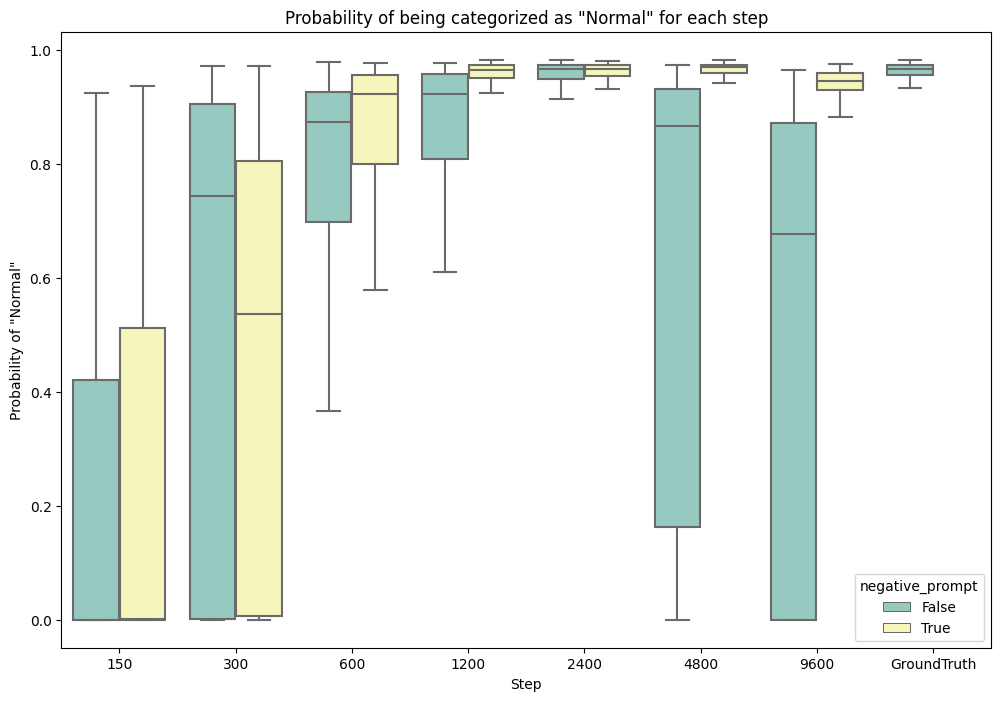

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='正常', hue='negative_prompt', data=df_combined, palette="Set3", showfliers = False)
plt.title('Probability of being categorized as "Normal" for each step')
plt.xlabel('Step')
plt.ylabel('Probability of "Normal"')
plt.show()


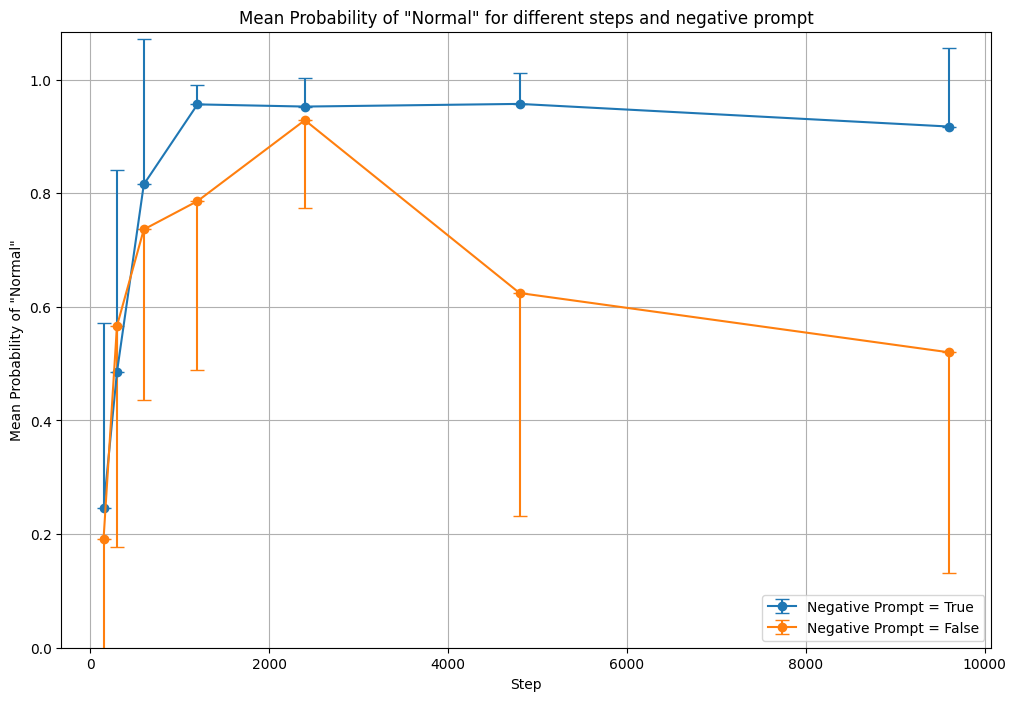

In [ ]:
import matplotlib.pyplot as plt

# Separate dataframes for negative_prompt == True and False
df_true = stats_df[stats_df['negative_prompt'] == True]
df_false = stats_df[stats_df['negative_prompt'] == False]

# Set y limit
ylim_max = max((df_true['mean'] + df_true['std']).max(), (df_false['mean'] + df_false['std']).max())

# Plotting with corrected error bars
plt.figure(figsize=(12, 8))

plt.errorbar(df_true['step'], df_true['mean'], yerr=[[0]*len(df_true['std']), df_true['std']],
             fmt='-o', capsize=5, label='Negative Prompt = True')
plt.errorbar(df_false['step'], df_false['mean'], yerr=[df_false['std'], [0]*len(df_false['std'])],
             fmt='-o', capsize=5, label='Negative Prompt = False')

plt.xlabel('Step')
plt.ylabel('Mean Probability of "Normal"')
plt.ylim(0, ylim_max)
plt.legend()
plt.grid(True)
plt.title('Mean Probability of "Normal" for different steps and negative prompt')
plt.show()



###**各ステップ数における尤度の比較**



In [ ]:
from scipy.stats import shapiro

df_filtered = df_combined[df_combined['negative_prompt'] == False].sort_values(by='step')


# Check if the data follow a normal distribution for each step
normality_test_results = {step: shapiro(df_filtered[df_filtered['step'] == step]['正常']).pvalue
                          for step in df_filtered['step'].unique()}
normality_test_results

# →データが正規分布でないためKruskak-Wallis検定を行う

In [ ]:
from scipy.stats import kruskal

# Prepare data for each step
data_for_test = [df_filtered[df_filtered['step'] == step]['正常'] for step in df_filtered['step'].unique()]

# Perform the Kruskal-Wallis H test
h, p = kruskal(*data_for_test)

h, p

# → Kruskal-Wallis検定では有意差あり

In [ ]:
from scipy.stats import mannwhitneyu
from itertools import combinations

"""
#　事後検定(各群間の有意差を、Mann-Whitney-Uを用いて算出)
"""

# Get the unique steps
steps = df_filtered['step'].unique()

# Calculate the number of pairs for Bonferroni correction
num_pairs = len(list(combinations(steps, 2)))

# Perform Mann-Whitney U tests for each pair of steps
p_values = {}
for step1, step2 in combinations(steps, 2):
    data1 = df_filtered[df_filtered['step'] == step1]['正常']
    data2 = df_filtered[df_filtered['step'] == step2]['正常']
    _, p = mannwhitneyu(data1, data2, alternative='two-sided')
    p_values[(step1, step2)] = p / num_pairs  # Apply Bonferroni correction


# Convert the p-values into a dataframe
p_values_df = pd.DataFrame(index=steps, columns=steps)

# Fill the dataframe with the p-values
for (step1, step2), p in p_values.items():
    p_values_df.loc[step1, step2] = p
    p_values_df.loc[step2, step1] = p

p_values_df.fillna(1, inplace=True)  # Fill the diagonal with 1s

p_values_df



###**Negative promptの有無による比較**

Negative promptの有無による尤度をMann-Whitney U検定で比較する

In [ ]:
# Perform a Mann-Whitney U test for each step, comparing '正常' between negative_prompt True and False
p_values_prompt = {}

for step in df_combined['step'].unique():
    data_true = df_combined[(df_combined['step'] == step) & (df_combined['negative_prompt'] == True)]['正常']
    data_false = df_combined[(df_combined['step'] == step) & (df_combined['negative_prompt'] == False)]['正常']
    _, p = mannwhitneyu(data_true, data_false, alternative='two-sided')
    p_values_prompt[step] = p

p_values_prompt


{150: 0.0241409730858071,
 300: 0.03648007105857532,
 600: 0.0005807527273056413,
 1200: 4.1415898267000536e-13,
 2400: 0.8805528499565746,
 4800: 9.089887024420262e-25,
 9600: 1.4661715835156567e-22}

In [ ]:
##ちなみに対応のないt-testだとこちら

from scipy.stats import ttest_ind

dataframes = {}
for csv_file in csv_files:
    dataframes[csv_file] = pd.read_csv(csv_file, encoding='cp932')
    print(csv_file)

# Prepare a dictionary to store the results
t_test_results = {}

# Loop over each unique step number
#step_numbers = [150, 300, 600, 1200, 2400, 4800, 9600]
step_numbers = set([int(os.path.splitext(os.path.basename(name))[0]) for name in csv_files if os.path.splitext(os.path.basename(name))[0].isdigit()])
step_numbers = sorted(step_numbers)

for step in step_numbers:
    # Find corresponding dataframe names
    df_name1 = f'{os.path.dirname(csv_file)}/{step}.csv'
    df_name2 = f'{os.path.dirname(csv_file)}/{step}_negative.csv'

    # If both dataframes exist, perform the t-test
    if df_name1 in dataframes and df_name2 in dataframes:
        df1 = dataframes[df_name1]
        df2 = dataframes[df_name2]

        # Perform the t-test on the "正常" column
        t_stat, p_val = ttest_ind(df1["正常"], df2["正常"])
        t_test_results[step] = (t_stat, p_val)

t_test_results #


#**FID scoreを用いた画質の評価**

FID for Pytorch
https://github.com/mseitzer/pytorch-fid

FID scoreとは？？
https://data-analytics.fun/2021/12/31/understanding-fid/

In [ ]:
!pip install pytorch_fid


In [ ]:
!unzip "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/generated_normal.zip" -d "/content/generated_normal"

In [ ]:
# Resize images to 299x299 pixcels
from PIL import Image
from tqdm import tqdm
import os

def resize_images(folder_path, size=(299, 299)):
    files_to_resize = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                files_to_resize.append(os.path.join(root, file))

    for file_path in tqdm(files_to_resize, desc=f'Resizing images in {folder_path}'):
        img = Image.open(file_path)
        img_resized = img.resize(size)
        img_resized.save(file_path)

# Resize images in the 'true' folder
true_folder = '/content/generated_normal/true'
resize_images(true_folder)

# Resize images in other folders
parent_folder = '/content/generated_normal'
folders = os.listdir(parent_folder)
for folder in folders:
    if folder == 'true':
        continue
    other_folder = os.path.join(parent_folder, folder)
    resize_images(other_folder)

In [ ]:
import os
import pandas as pd

# Path to the folder with the real images
true_images_folder = '/content/generated_normal/true'

# Path to the parent folder of the generated images
parent_folder = '/content/generated_normal'

# Get a list of all folders in the parent folder
folders = os.listdir(parent_folder)

# Create an empty dataframe to store FID scores
fid_scores = pd.DataFrame(columns=['folder', 'fid_score'])

for folder in folders:
    if folder == 'true':
        continue
    other_folder = os.path.join(parent_folder, folder)

    # Calculate the FID score
    fid_score = !python -m pytorch_fid {true_folder} {other_folder}  # Note: replace this with your FID calculation command
    print(fid_score)
    fid_score = float(fid_score[11].split(':')[1].strip())  # Note: adjust this line based on the output of your FID calculation command
    fid_score = round(fid_score, 2) #round FID value to two decimal places

    # Add the FID score to the dataframe
    print(f"{folder}: {fid_score}")
    current_score = pd.DataFrame({'folder': [folder], 'fid_score': [fid_score]})
    fid_scores = pd.concat([fid_scores, current_score], ignore_index=True)

# Print the dataframe
print(fid_scores)

In [ ]:
# Extract the step number and whether the row is negative into new columns
fid_scores['step'] = fid_scores['folder'].str.extract('(\d+)').astype(int)
fid_scores['negative'] = fid_scores['folder'].str.contains('negative')

# Sort by the new columns
fid_scores_sorted = fid_scores.sort_values(['step', 'negative'])

# Reset the index of the sorted DataFrame
fid_scores_sorted = fid_scores_sorted.reset_index(drop=True)

# Print the sorted DataFrame
fid_scores_sorted


,folder,fid_score,step,negative
0,step150,221.99,150,False
1,step150_negative,215.38,150,True
2,step300,211.04,300,False
3,step300_negative,206.31,300,True
4,step600,184.78,600,False
5,step600_negative,172.12,600,True
6,step1200,182.15,1200,False
7,Step1200_negative,200.74,1200,True
8,step2400,180.54,2400,False
9,step2400_negative,182.80,2400,True


In [ ]:
import matplotlib.pyplot as plt

# Create a figure and an axis
fig, ax = plt.subplots()

# For each value of 'negative'
for negative in [True, False]:
    # Select the rows where 'negative' is the current value
    subset = fid_scores_sorted[fid_scores_sorted['negative'] == negative]
    # Plot 'step' vs 'fid_score' for the selected rows
    ax.plot(subset['step'], subset['fid_score'], label=f'negative={negative}')

# Add title and labels
ax.set_title('FID Score by Step Number')
ax.set_xlabel('Step Number')
ax.set_ylabel('FID Score')

# Add a legend
ax.legend()

# Display the plot
plt.show()


#**人力評価用データセットの作成**

In [ ]:
!unzip "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/generated_normal.zip" -d "/content/generated_normal"

#**サマリー画像作成**

フォルダ内の画像からランダムで9枚選択して隙間なく配置（学会発表、論文用）

In [ ]:
import os

base_dir = 'C:\\Users\\CorneAI\\Desktop\\角膜翼状片画像生成\\123mai'
#base_dir = 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成'
folders = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

folders.append(r"C:\Users\CorneAI\sd-scripts\TrainingData_pterygium\train_image_768px")
folders

In [ ]:
base_dir = 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成'
folders = ['C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step1200',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step1200_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step150',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step150_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step2400',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step2400_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step300',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step300_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step4800',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step4800_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step600',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step600_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step9600',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\step9600_negative',
 'C:\\Users\\CorneAI\\Desktop\\角膜正常画像生成\\GroundTruth'
  ]
folders


###**3x3の配列**

In [ ]:
import os
import random
from PIL import Image

def create_mosaic(folder_path, output_folder, num_images=9, grid_size=3):
    # Get a list of all the image files in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Check if there are enough images in the folder
    if len(images) < num_images:
        print(f"Folder {folder_path} does not contain enough images. Skipping this folder.")
        return

    # Randomly select num_images from the list of images
    selected_images = random.sample(images, num_images)

    # Open the images
    image_objects = [Image.open(os.path.join(folder_path, img)) for img in selected_images]

    # Create a new blank image with dimensions to hold the 3x3 array of the images
    mosaic = Image.new('RGB', (image_objects[0].width * grid_size, image_objects[0].height * grid_size))

    # Paste the images into the new image in a 3x3 grid
    for i in range(grid_size):
        for j in range(grid_size):
            mosaic.paste(image_objects[i * grid_size + j], (i * image_objects[0].width, j * image_objects[0].height))

    # Save the new image
    mosaic_path = os.path.join(output_folder, f"mosaic_{os.path.basename(folder_path)}.png")
    mosaic.save(mosaic_path)

    print(f"Mosaic image saved at: {mosaic_path}")

folders = folders
output_folder = base_dir

for folder in folders:
    create_mosaic(folder, output_folder)


Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_1200steps.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_1200steps_negative.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_150steps.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_150steps_negative.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_19200steps.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_19200steps_negative.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_2400steps.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_2400steps_negative.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_300steps.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成\123mai\mosaic_pte_300steps_negative.png
Mosaic image saved at: C:\Users\CorneAI\Desktop\角膜翼状片画像生成

####**3x1の配列**

In [ ]:
import os
import random
from PIL import Image
from IPython.display import display

def create_mosaic(folder_path, output_folder, num_images=3, grid_size=(3,1)):
    # Get a list of all the image files in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Check if there are enough images in the folder
    if len(images) < num_images:
        print(f"Folder {folder_path} does not contain enough images. Skipping this folder.")
        return

    # Randomly select num_images from the list of images
    selected_images = random.sample(images, num_images)

    # Open the images
    image_objects = [Image.open(os.path.join(folder_path, img)) for img in selected_images]

    # Create a new blank image with dimensions to hold the grid of the images
    mosaic = Image.new('RGB', (image_objects[0].width * grid_size[1], image_objects[0].height * grid_size[0]))

    # Paste the images into the new image in a grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            mosaic.paste(image_objects[i * grid_size[1] + j], (j * image_objects[0].width, i * image_objects[0].height))

    # Save the new image
    mosaic_path = os.path.join(output_folder, f"mosaic_{os.path.basename(folder_path)}.png")
    mosaic.save(mosaic_path)

    print(f"Mosaic image saved at: {mosaic_path}")

    # Display the image in Jupyter notebook
    #display(Image.open(mosaic_path))

folders = folders
output_folder = base_dir

for folder in folders:
    create_mosaic(folder, output_folder)
